In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

In [9]:
from Simulation import *

env, observations_probabilities = generate_new_environment()

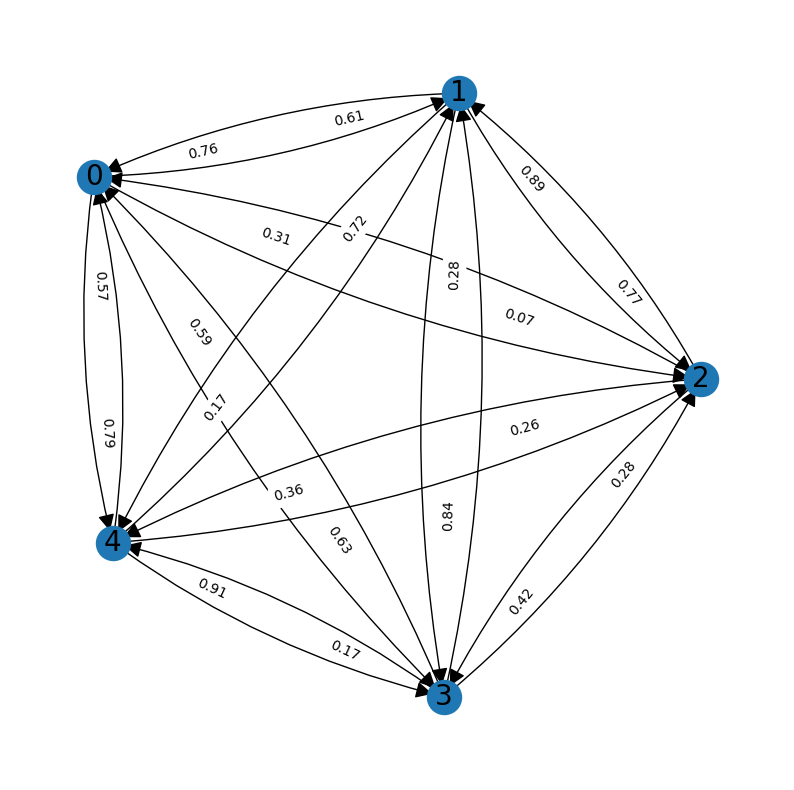

In [10]:
from Network import *
Network.print_graph(env.get_network().G)

In [5]:
ecomm = Ecommerce(B_cap, budgets, product_prices, observations_probabilities)

In [21]:
exp_clicks = env.estimate_expected_user_alpha(ecomm.budgets / ecomm.B_cap)
nodes_activation_probabilities, num_items_sold = estimate_nodes_activation_probabilities(
            env.network.get_adjacency_matrix(), env.get_users_reservation_prices(), ecomm.product_prices, observations_probabilities)


In [26]:
optimal_allocation = ecomm.solve_optimization_problem(
    env.get_network().get_adjacency_matrix(), num_items_sold, env.get_users_reservation_prices(), exp_clicks, nodes_activation_probabilities)


optimal solution found is: [40. 80. 40. 40.  0.]


In [27]:
matr = np.ones((5, 11))

In [28]:
arr = np.array([0, 1,2,3,4])

In [32]:
np.multiply(matr.T, arr).T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])

In [36]:
from Ecommerce3 import *
from Ecommerce4 import *

In [40]:
# -----------STEP 3------------
gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []

for e in tqdm(range(0, n_experiments), position=0, desc="n_experiment", leave=False):
    env, _ = generate_new_environment()

    ecomm3_gpts = Ecommerce3_GPTS(
        B_cap, budgets, product_prices)
    ecomm3_ucb = Ecommerce3_GPUCB(
        B_cap, budgets, product_prices)

    for t in tqdm(range(0, T), position=1, desc="n_iteration", leave=False):
        arm = ecomm3_gpts.pull_arm(num_items_sold)
        reward = env.round_step3(arm)
        ecomm3_gpts.update(arm, reward)

        arm = ecomm3_ucb.pull_arm(num_items_sold)
        reward = env.round_step3(arm)
        ecomm3_ucb.update(arm, reward)

    gpts_rewards_per_experiment.append(ecomm3_gpts.collected_rewards)
    gpucb_rewards_per_experiment.append(ecomm3_ucb.collected_rewards)

opt = opt = np.sum(env.get_users_alpha(), axis=0)[1:]
# this np.mean is used to compute the average regret for each "product" -> output shape = (n_experiments x NUM_OF_PRODUCTS)

gpts_regret_superarm = opt - np.mean(np.array(gpucb_rewards_per_experiment), axis=0).T
gpucb_regret_superarm = opt - np.mean(np.array(gpts_rewards_per_experiment), axis=0).T 

gpts_regret_per_round = np.sum(gpts_regret_superarm, axis = 1)
gpucb_regret_per_round = np.sum(gpucb_regret_superarm, axis=1) 

# # this np.mean before of the cumsum is to average over all the products
gpts_regret = np.cumsum(gpts_regret_per_round)
gpucb_regret = np.cumsum(gpucb_regret_per_round)

plot_regrets(gpts_regret, gpucb_regret)

KeyboardInterrupt: 

In [42]:
# -----------STEP 4------------
gpucb_rewards_per_experiment = []
gpts_rewards_per_experiment = []

for e in tqdm(range(0, n_experiments), position=0, desc="n_experiment", leave=False):
    env, _ = generate_new_environment()

    ecomm4_gpts = Ecommerce4_GPTS(
        B_cap, budgets, product_prices)
    ecomm4_ucb = Ecommerce4_GPUCB(
        B_cap, budgets, product_prices)

    for t in tqdm(range(0, T), position=1, desc="n_iteration", leave=False):
        arm = ecomm4_ucb.pull_arm()
        reward = env.round_step3(arm)
        ecomm3_ucb.update(arm, reward)

        arm = ecomm4_gpts.pull_arm()
        reward = env.round_step3(arm)
        ecomm4_gpts.update(arm, reward)

    gpucb_rewards_per_experiment.append(ecomm4_ucb.collected_rewards)
    gpts_rewards_per_experiment.append(ecomm4_gpts.collected_rewards)

opt = opt = np.sum(env.get_users_alpha(), axis=0)[1:]
# this np.mean is used to compute the average regret for each "product" -> output shape = (n_experiments x NUM_OF_PRODUCTS)

gpts_regret_superarm = opt - np.mean(np.array(gpucb_rewards_per_experiment), axis=0).T
gpucb_regret_superarm = opt - np.mean(np.array(gpts_rewards_per_experiment), axis=0).T 

gpts_regret_per_round = np.sum(gpts_regret_superarm, axis = 1)
gpucb_regret_per_round = np.sum(gpucb_regret_superarm, axis=1) 

# # this np.mean before of the cumsum is to average over all the products
gpts_regret = np.cumsum(gpts_regret_per_round)
gpucb_regret = np.cumsum(gpucb_regret_per_round)

plot_regrets(gpts_regret, gpucb_regret)

KeyboardInterrupt: 

n_experiment:   0%|          | 0/10 [00:00<?, ?it/s]

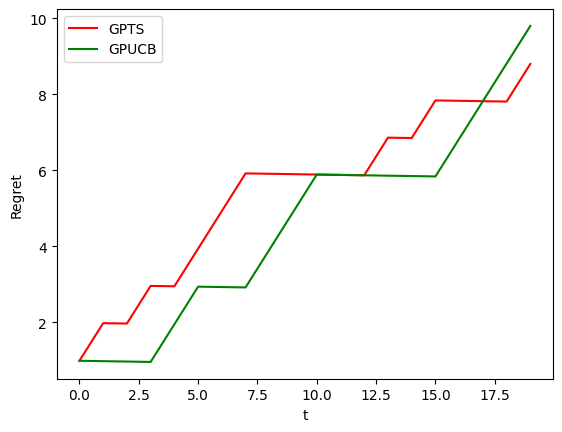

n_experiment:  10%|█         | 1/10 [00:07<01:09,  7.77s/it]

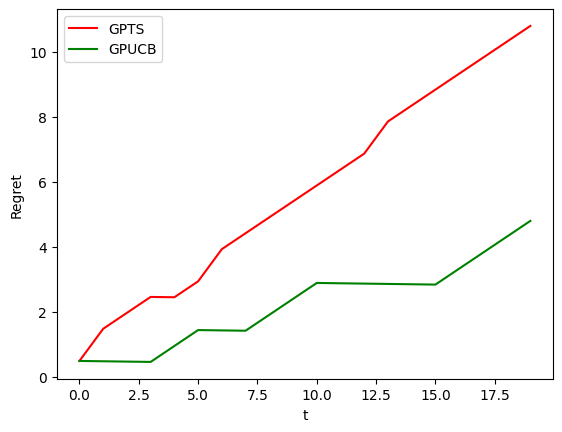

KeyboardInterrupt: 

In [44]:
# -----------STEP 5------------

gpucb_rewards_per_experiment = []
gpts_rewards_per_experiment = []

for e in tqdm(range(0, n_experiments), position=0, desc="n_experiment", leave=False):
    env, observations_probabilities = generate_new_environment()

    ecomm5_gpts = Ecommerce5_GPTS(
        B_cap, budgets, product_prices)
    ecomm5_ucb = Ecommerce5_UCB(
        B_cap, budgets, product_prices)

    for t in tqdm(range(0, T), position=1, desc="n_iteration", leave=False):
        arm, arm_idx = ecomm5_ucb.pull_arm()
        reward = env.round_step5(arm)
        ecomm5_ucb.update(arm_idx, reward)

        arm, arm_idx = ecomm5_gpts.pull_arm()
        reward = env.round_step5(arm)
        ecomm5_gpts.update(arm_idx, reward)

    gpucb_rewards_per_experiment.append(ecomm5_ucb.collected_rewards)
    gpts_rewards_per_experiment.append(ecomm5_gpts.collected_rewards)

opt = np.max(env.get_network().get_adjacency_matrix())

gpts_regret = np.cumsum(
    np.mean(opt - gpucb_rewards_per_experiment, axis=0))
gpucb_regret = np.cumsum(
    np.mean(opt - gpts_rewards_per_experiment, axis=0))

plot_regrets(gpts_regret, gpucb_regret)


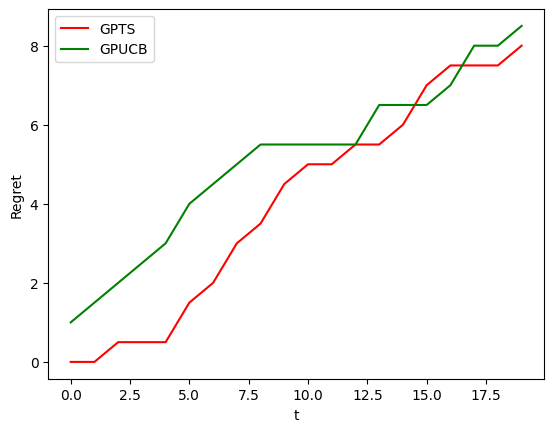

In [83]:
gpucb_rewards_per_experiment = []
gpts_rewards_per_experiment = []

for e in tqdm(range(0, 2), position=0, desc="n_experiment", leave=False):
env, observations_probabilities = generate_new_environment()

ecomm5_gpts = Ecommerce5_GPTS(
    B_cap, budgets, product_prices, observations_probabilities)
ecomm5_ucb = Ecommerce5_UCB(
    B_cap, budgets, product_prices, observations_probabilities)

for t in tqdm(range(0, 20), position=1, desc="n_iteration", leave=False):
    arm, arm_idx = ecomm5_ucb.pull_arm()
    reward = env.round_step5(arm)
    ecomm5_ucb.update(arm_idx, reward)

    arm, arm_idx = ecomm5_gpts.pull_arm()
    reward = env.round_step5(arm)
    ecomm5_gpts.update(arm_idx, reward)

gpucb_rewards_per_experiment.append(ecomm5_ucb.collected_rewards)
gpts_rewards_per_experiment.append(ecomm5_gpts.collected_rewards)

opt = np.max(env.get_network().get_adjacency_matrix())

gpts_regret = np.cumsum(
np.mean(opt - gpucb_rewards_per_experiment, axis=0))
gpucb_regret = np.cumsum(
np.mean(opt - gpts_rewards_per_experiment, axis=0))

plot_regrets(gpts_regret, gpucb_regret)